In [1]:
# For Google Colaboratory
import sys, os,time
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS6208_PaperReview/'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    !pip3 install dgl -f https://data.dgl.ai/wheels/cu118/repo.html
    !pip3 install networkx
    !pip3 install matplotlib
    !pip3 install torch_geometric # Install PyG
    !pip3 install ogb
    !pip3 install grakel
    !pwd

# 3.2.1 Weisfeiler-Lehman Subtree Kernel

In [2]:
# [(n, list(nbrdict.keys())) for n, nbrdict in Graphs[i].adjacency()]

In [3]:
import copy 
from functools import reduce
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import numpy.matlib as matlib
import pandas as pd
# trainning
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#
import grakel

In [4]:
## try algorithm 
def plot_graph_with_color(Graph, labels, ax, colors = None, COLOR_SCHEME = 'Set1'):
    """
    """
    if colors is None:
        colors = [labels[node] for node in list(Graph.nodes())]
    nx.draw_networkx(Graph, labels=labels, with_labels=True, node_color=colors, cmap=COLOR_SCHEME, ax=ax)

def WL_General(Graphs, n_iters=1 , verbose = False, use_label=1):
    """
    computes the Weisfeiler-Lehman subtree kernel
    Input:
    - Graphs
        n Graph in Graphs:
        {0: {'Graph': <networkx.classes.graph.Graph at 0x7f20835dc310>,
          'labels': {0: 1, 1: 1, 2: 4, 3: 3, 4: 5, 5: 2}},
         1: {'Graph': <networkx.classes.graph.Graph at 0x7f20835ddc30>,
          'labels': {0: 1, 1: 4, 2: 2, 3: 5, 4: 3, 5: 2}}}
    - verbose: plot to check each step in 1st iteration 
    - n_iters: n iteration 
    Output:
        K kernel - array for the matrix kernel with length < n_iters
        K[0] --> the kernel compute when not run iteration
        K[1] --> the kernel compute after running iteration 1
        K[2] --> the kernel compute after running iteration 2
        ....
        K[n_iters] -> the kernel compute after running iteration n_iters
    """
    numGraph = len(Graphs)
    labels = {}
    label_lookup = {}
    label_counter = 0
    total_node = 0
    for i in range(numGraph):
        total_node = total_node + len(Graphs[i]["Graph"].nodes())
    phi = np.zeros((total_node, numGraph)) ## Will transfer to sparse matrix later!!!!!!!!!!!!!!!!!!!!!!!!!
    K = []
    
    ## initialize in case having labels
    if use_label == 1:
        for i in range(numGraph):
            labels[i] = np.zeros(len(Graphs[i]["Graph"].nodes)).astype(int)
            for j in Graphs[i]["Graph"].nodes():
                i_label = Graphs[i]["labels"]
                str_label = "{}".format(i_label[j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
                phi[labels[i][j], i] = phi[labels[i][j], i] + 1    
    # In case not having the label --> using page rank 
    else:
        #  ONE TO ONE node degree
         for i in range(numGraph):
            labels[i] = nx.to_numpy_array(Graphs[i]["Graph"]).sum(axis = 1).astype(int)
            for j in range(len(labels[i])):
                str_label = "{}".format(labels[i][j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
                phi[labels[i][j], i] = phi[labels[i][j], i] + 1 
    original_label = copy.deepcopy(labels)
    original_count = label_counter
    if (verbose == True) and (numGraph <= 5):
        fig, axs = plt.subplots(nrows=1, ncols=numGraph, figsize=(20,5))
        for iGraph, ax in zip(Graphs.keys(), axs.ravel()):
            ax.set_title('Graph {}'.format(iGraph))
            reversed_dict = dict(map(reversed, label_lookup.items()))
            # ilabel = {in_: int(reversed_dict[labels[iGraph][in_]]) for in_ in Graphs[iGraph]["Graph"].nodes()}
            ilabel = {in_: labels[iGraph][in_] for in_ in Graphs[iGraph]["Graph"].nodes()}
            colors = [labels[iGraph][node] for node in list(Graphs[iGraph]["Graph"].nodes())]
            plot_graph_with_color(Graphs[iGraph]["Graph"],  ilabel, ax, colors)
            # plot_graph_with_color(Graphs[iGraph]["Graph"],  Graphs[iGraph]["labels"], ax)
        fig.suptitle(' Initalize Labels ', fontsize=18)
    K= [ phi.T@phi]
    new_labels = copy.deepcopy(labels)
    for i_iter in range(n_iters):
        label_lookup = {}
        label_counter = 0
        phi = np.zeros((total_node, numGraph)) ## Will transfer to sparse matrix later!!!!!!!!!!!!!!!!!!!!!!!!!
        #
        for i in range(numGraph):
            i_Graph = Graphs[i]["Graph"]
            # print("-------------------------")
            for node in i_Graph.nodes():
                l_neibor = [str(labels[i][ii]) for ii in i_Graph[node]]
                i_new_labels = "{},".format(labels[i][node]) +"".join(sorted(l_neibor)) ## should we as type?
                # print(i, node, i_new_labels)
                if i_new_labels not in label_lookup:
                    label_lookup[i_new_labels] = label_counter
                    new_labels[i][node] = label_counter
                    label_counter = label_counter + 1
                else:
                    new_labels[i][node] = label_lookup[i_new_labels]
                # print(new_labels[i][node])
                # phi[new_labels[i][node], i] = phi[new_labels[i][node], i] + 1
            aux =np.bincount(new_labels[i], weights=np.ones((len(new_labels[i]))))
            phi[new_labels[i], i] = phi[new_labels[i], i] + aux[new_labels[i]]
        if (verbose == True) and (numGraph <= 5):
            if i_iter == 0:
                fig, axs = plt.subplots(nrows=1, ncols=numGraph, figsize=(20,5))
                for iGraph, ax in zip(Graphs.keys(), axs.ravel()):
                    ax.set_title('Graph {}'.format(iGraph))
                    reversed_dict = dict(map(reversed, label_lookup.items()))
                    ilabel = {in_: reversed_dict[labels[iGraph][in_]] for in_ in Graphs[iGraph]["Graph"].nodes()}
                    colors = [original_label[iGraph][node] for node in list(Graphs[iGraph]["Graph"].nodes())]
                    plot_graph_with_color(Graphs[iGraph]["Graph"],  ilabel, ax, colors)
                    # plot_graph_with_color(Graphs[iGraph]["Graph"],  Graphs[iGraph]["labels"], ax)
                fig.suptitle(' 1st iteration - Steps 1 & 2 Multiset Label Determination & Sorting ', fontsize=18)
                #
                fig, axs = plt.subplots(nrows=1, ncols=numGraph, figsize=(20,5))
                for iGraph, ax in zip(Graphs.keys(), axs.ravel()):
                    ax.set_title('Graph {}'.format(iGraph))
                    reversed_dict = dict(map(reversed, label_lookup.items()))
                    ilabel = {in_: labels[iGraph][in_] + original_count  for in_ in Graphs[iGraph]["Graph"].nodes()}
                    colors = [ilabel[node] for node in list(Graphs[iGraph]["Graph"].nodes())]
                    plot_graph_with_color(Graphs[iGraph]["Graph"],  ilabel, ax, colors)
                    # plot_graph_with_color(Graphs[iGraph]["Graph"],  Graphs[iGraph]["labels"], ax)
                fig.suptitle('1st iteration - Steps 4 relabeling ', fontsize=18)
                original_count += label_counter
        intersect = reduce(set.intersection, [set(l_) for l_ in list(new_labels.values())])
        if len(intersect) == 0:
            break
        i_K =  K[i_iter] + phi.T@phi
        K.append(i_K)
        labels = copy.deepcopy(new_labels)
    return K

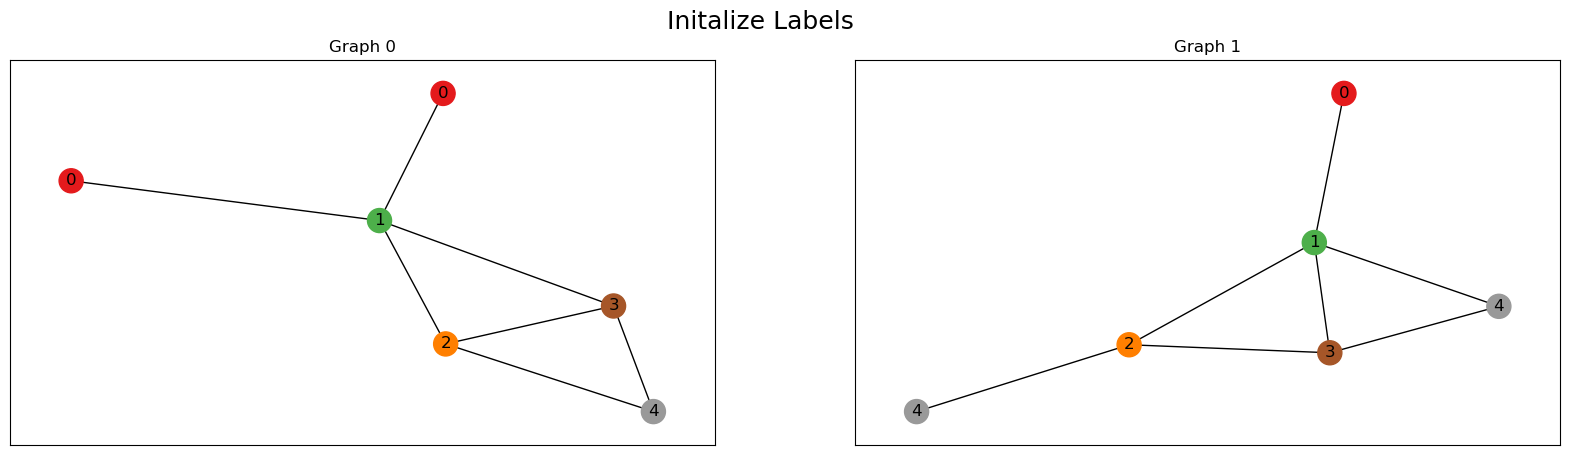

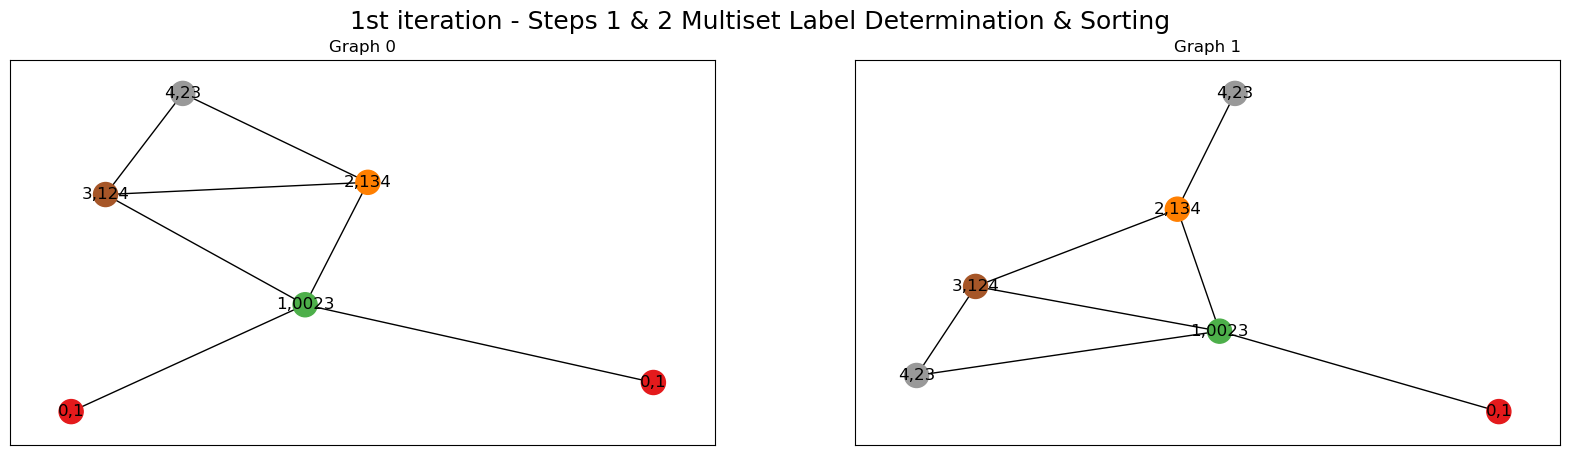

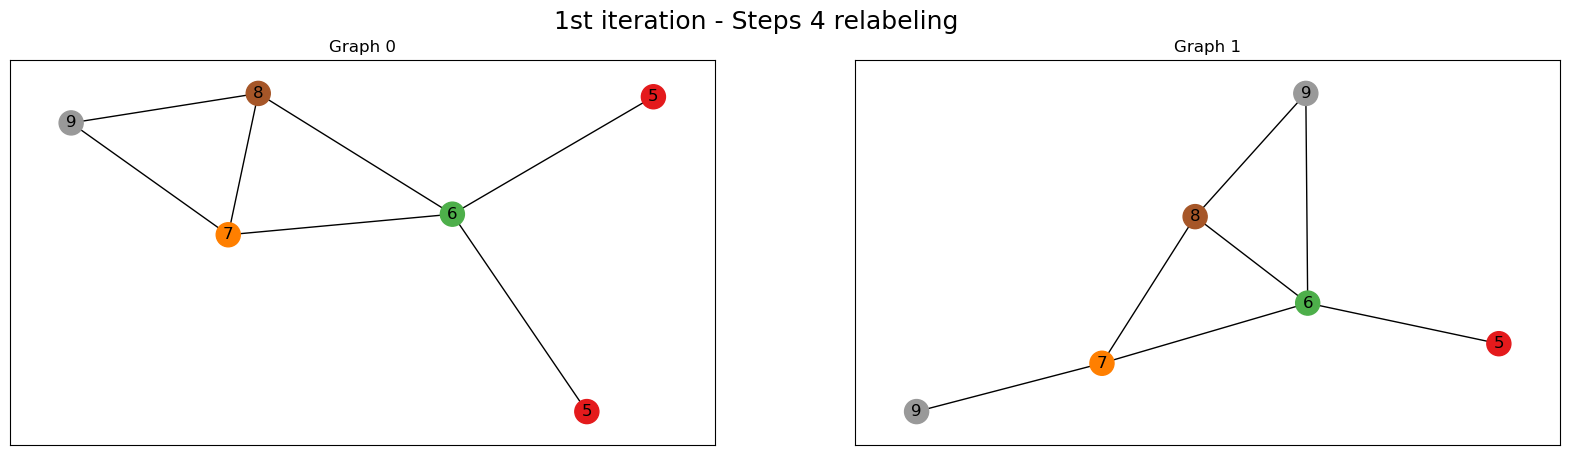

In [5]:
G1 = nx.Graph([(0, 2), (1, 2), (2, 3), (2, 4), (2, 3), (3, 4), (3, 5), (4, 5)])
labels_G1 = {}
labels_G1[0] = 1
labels_G1[1] = 1
labels_G1[2] = 4
labels_G1[3] = 3
labels_G1[4] = 5
labels_G1[5] = 2
#--------------
G2 = nx.Graph([(0, 1), (1, 2), (1, 3), (1, 4), (2, 3), (3, 4), (4, 5)])
labels_G2 = {0: 1, 1: 4, 2: 2, 3:5, 4:3, 5:2}

Graphs = {}
Graphs[0] = {}
Graphs[0]["Graph"] = G1
Graphs[0]["labels"] = labels_G1
Graphs[1] = {}
Graphs[1]["Graph"] = G2
Graphs[1]["labels"] = labels_G2
# --------------------------------------------------------------
K_general = WL_General(Graphs,  3, verbose = True)



In [6]:
print(K_general)

[array([[8., 7.],
       [7., 8.]]), array([[16., 11.],
       [11., 14.]])]


## 3.2.2 - 3.2.3 Ramon & Gaerthner subtree kernel

In [7]:
def RGkernel(Graphs, k, use_label = 1):
    """
    Compute  Ramon and Gaertner subtree kernel  based on Ramon & Gaethner algorithm 
    """
    numGraph = len(Graphs)
    K = np.zeros([numGraph, numGraph])
    label_lookup = {}
    labels = {}
    label_counter = 0
    total_node = 0
    if use_label == 1:
        for i in range(numGraph):
            labels[i] = np.zeros(len(Graphs[i]["Graph"].nodes)).astype(int)
            for j in Graphs[i]["Graph"].nodes():
                i_label = Graphs[i]["labels"]
                str_label = "{}".format(i_label[j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
    # In case not having the label --> using page rank 
    else:
        #  ONE TO ONE node degree
         for i in range(numGraph):
            labels[i] = nx.to_numpy_array(Graphs[i]["Graph"]).sum(axis = 1).astype(int)
            for j in range(len(labels[i])):
                str_label = "{}".format(labels[i][j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
    
    def flatten(l):
        """ local flatten function """
        return [item for sublist in l for item in sublist]
    for i in range(numGraph):
        for j in range(i, numGraph):

            i_Graph = Graphs[i]["Graph"]
            di_label =  labels[i]
            j_Graph = Graphs[j]["Graph"]
            dj_label = labels[j]
            ##-----------------------
            nodes_i = np.array([ii for ii in Graphs[i]["Graph"].nodes()])
            nodes_j = np.array([ii for ii in Graphs[j]["Graph"].nodes()])
            llabel_i = [di_label[ii] for ii in Graphs[i]["Graph"].nodes()]
            llabel_j = [dj_label[ii] for ii in Graphs[j]["Graph"].nodes()]
            ##
            temp_i = matlib.repmat(np.asmatrix(llabel_i).T, 1, len(llabel_j))
            temp_j = matlib.repmat(np.asmatrix(llabel_j),len(llabel_i), 1)
            k_nodes = np.array(temp_i ==  temp_j).astype(float)
            
            K[i, j] = k_nodes.sum() # in case can not run the heigth 
            for h in range(2, k + 1):
                K[i, j] = 0
                k_nodes_new = np.zeros_like(k_nodes)
                for vi in i_Graph.nodes():
                    for vj in j_Graph.nodes():
                        kvij = 0 
                        if di_label[vi] == dj_label[vj]:
                            lnbi = np.array([di_label[inb] for inb in i_Graph.neighbors(vi)])
                            lnbj = np.array([dj_label[jnb] for jnb in j_Graph.neighbors(vj)])
                            #
                            nbi = [inb for inb in i_Graph.neighbors(vi)]
                            nbj = [jnb for jnb in j_Graph.neighbors(vj)]
                            # print(vi, di_label[vi], nbi, lnbi,"|" , vj, dj_label[vj], nbj, lnbj)
                            if len(lnbi) + len(lnbj) == 0:
                                M = []
                            else:
                                remat_i = matlib.repmat(np.asmatrix(lnbi).T, 1, len(lnbj)) 
                                remat_j = matlib.repmat(np.asmatrix(lnbj), len(lnbi), 1)
                                M = remat_i == remat_j
                                # print(M)
                                ind1_, ind2_ = np.where(M == True)
                                ind1 = [nbi[ii] for ii in ind1_]
                                ind2 = [nbj[ii] for ii in ind2_]
                                pairs = np.array([ind1, ind2]).T

                                common_labels = set.intersection(set(lnbi), set(lnbj))
                                max_matching_size = 0
                                for ic in common_labels:
                                    max_matching_size = max_matching_size + min(sum((lnbi == ic).astype(int)), sum((lnbj == ic).astype(int)))

                                matching = {}
                                # print("i, j",  nodes_i, nodes_j, pairs)
                                if len(pairs) > 0:
                                    for ii, i_pairs in enumerate(pairs):
                                        matching[ii] = [ii]
                                        loc_node_i = np.where(nodes_i == i_pairs[0])[0][0]
                                        loc_node_j = np.where(nodes_j == i_pairs[1])[0][0]
                                        # if loc_node_i >= k_nodes.shape[0]:
                                        #     loc_node_i = k_nodes.shape[0] - 1
                                        # if loc_node_j >= k_nodes.shape[1]:
                                        #     loc_node_j = k_nodes.shape[1] - 1
                                        kvij = kvij + k_nodes[loc_node_i, loc_node_j]
             
                                for m in range(2, max_matching_size + 1): ## why this is 2!!!!
                                    new_matching = {}
                                    new_matching_counter = 1
                                    for l in range(len(matching)): # should i + 1
                                        for n in range(l, len(pairs)):
                                            pair_0 = [pairs[i0][0] for i0 in matching[l]]
                                            pair_1 = [pairs[i0][1] for i0 in matching[l]]

                                            if any(pair_0 == pairs[n][0]) or any(pair_1 == pairs[n][1]):
                                                continue
                                            # new_matching[new_matching_counter] = flatten([matching[l], n])
                                            new_matching[new_matching_counter] = flatten([matching[l], [n]])
                                            prod = 1
                                            for p in new_matching[new_matching_counter]:
                                                i_pairs = pairs[p]
                                                prod = prod* k_nodes[np.where(nodes_i == i_pairs[0])[0][0], np.where(nodes_j == i_pairs[1])[0][0]]
                                            kvij = kvij + prod
                                            new_matching_counter = new_matching_counter + 1
                                    matching.update(new_matching)
                            k_nodes_new[vi, vj] = kvij
                            K[i,j] = K[i,j] + kvij   
                k_nodes = k_nodes_new
            K[j, i] = K[i, j]
            # print("Kernel value for the pair of graph [",i,j,"] computed")
    return K

In [8]:
K1 = RGkernel(Graphs, 2)
K1

array([[64., 36.],
       [36., 45.]])

# 3.3 The Weisfeiler-Lehman Edge Kernel

In [9]:
use_label = 1

In [10]:
def WL_Edge(Graphs, n_iters=1 , verbose = False, use_label=1):
    """ 
        This is source code for Weisfeiler Lehman Edge Kernel
    """
    numGraph = len(Graphs)
    labels = {}
    label_lookup = {}
    label_counter = 0
    # total_node = 0
    # for i in range(numGraph):
    #     total_node = total_node + len(Graphs[i]["Graph"].nodes())
    K = []

    ## initialize in case having labels
    if use_label == 1:
        for i in range(numGraph):
            labels[i] = np.zeros(len(Graphs[i]["Graph"].nodes)).astype(int)
            for j in Graphs[i]["Graph"].nodes():
                i_label = Graphs[i]["labels"]
                str_label = "{}".format(i_label[j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
    # In case not having the label --> using node degree 
    else:
        #  ONE TO ONE node degree
         for i in range(numGraph):
            labels[i] = nx.to_numpy_array(Graphs[i]["Graph"]).sum(axis = 1).astype(int)
            for j in range(len(labels[i])):
                str_label = "{}".format(labels[i][j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]


    # in case dont have edge weight


    original_label = copy.deepcopy(labels)
    original_count = label_counter

    # ----------------------------
    L = label_counter - 1
    # print('Number of original Labels: ', L)
    # print('Number of potential edge features: ', L*(L+1)/2)

    K = []
    ed = np.zeros(( int(L*(L+1)/2), numGraph))
    for i in range(numGraph):
        labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
        a = np.minimum(labels_aux, labels_aux.T)
        b = np.maximum(labels_aux, labels_aux.T)

        A = nx.to_numpy_array(Graphs[i]['Graph'])
        I = np.triu((A!=0), 1)
        Ind = (np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2  + b[I] - a[I] + 1 ).astype(int)
        temp_Ind = copy.deepcopy(Ind)
        temp_Ind = np.ravel(temp_Ind)
        # temp_Ind[temp_Ind < 0] =  temp_Ind[temp_Ind < 0]  - temp_Ind.min()
        temp_Ind[temp_Ind < 0] = 0
        # # --- converst to non negative
        # minind = min(Ind)
        # diff = max(Ind) - minind
        aux = np.bincount(temp_Ind, weights=np.ones(I.sum()))
        ed[temp_Ind, i] = aux[temp_Ind]
    K.append(ed.T@ed)

    new_labels = copy.deepcopy(labels)
    for i_iter in range(n_iters):
        label_lookup = {}
        label_counter = 0

        #
        for i in range(numGraph):
            i_Graph = Graphs[i]["Graph"]
            # print("-------------------------")
            for node in i_Graph.nodes():
                l_neibor = [str(labels[i][ii]) for ii in i_Graph[node]]
                i_new_labels = "{},".format(labels[i][node]) +"".join(sorted(l_neibor)) ## should we as type?
                # print(i, node, i_new_labels)
                if i_new_labels not in label_lookup:
                    label_lookup[i_new_labels] = label_counter
                    new_labels[i][node] = label_counter
                    label_counter = label_counter + 1
                else:
                    new_labels[i][node] = label_lookup[i_new_labels]
        L = label_counter - 1
        labels = copy.deepcopy(new_labels)
        ed = np.zeros(( int(L*(L+1)/2), numGraph))
        for i in range(numGraph):
            labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
            a = np.minimum(labels_aux, labels_aux.T)
            b = np.maximum(labels_aux, labels_aux.T)
            A = nx.to_numpy_array(Graphs[i]['Graph'])
            I = np.triu((A!=0), 1)
            Ind = (np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2  + b[I] - a[I] + 1 ).astype(int)
            temp_Ind = copy.deepcopy(Ind)
            temp_Ind = np.ravel(temp_Ind)
            # temp_Ind[temp_Ind < 0] =  temp_Ind[temp_Ind < 0]  - temp_Ind.min()
            temp_Ind[temp_Ind < 0] = 0
            aux = np.bincount(temp_Ind, weights=np.ones(I.sum()))
            ed[temp_Ind, i] = aux[temp_Ind]        

        intersect = reduce(set.intersection, [set(l_) for l_ in list(new_labels.values())])
        if len(intersect) == 0:
            break
        i_K =  K[i_iter] + ed.T@ed
        K.append(i_K)
    return K

In [11]:
K_edge = WL_Edge(Graphs, n_iters=3 )

In [12]:
K_edge

[array([[19.,  7.],
        [ 7.,  7.]]),
 array([[38., 12.],
        [12., 14.]])]

# 3.4 . Shortest Path Kernel 

In [13]:
is_precompute = False
use_label = True
def WLsp_kernel(Graphs, n_iters=1 , use_label=1):
    """ 
    Compute shorted path WL kernel 
    
    """
    labels = {}
    label_lookup = {}
    label_counter = 0
    numGraph = len(Graphs) 
    if use_label == 1:
        for i in range(numGraph):
            labels[i] = np.zeros(len(Graphs[i]["Graph"].nodes)).astype(int)
            for j in Graphs[i]["Graph"].nodes():
                i_label = Graphs[i]["labels"]
                str_label = "{}".format(i_label[j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
    # In case not having the label --> using node degree 
    else:
        #  ONE TO ONE node degree
         for i in range(numGraph):
            labels[i] = nx.to_numpy_array(Graphs[i]["Graph"]).sum(axis = 1).astype(int)
            for j in range(len(labels[i])):
                str_label = "{}".format(labels[i][j])
                if str_label not in label_lookup.keys():
                    label_lookup[str_label] = label_counter
                    labels[i][j] = label_counter
                    label_counter = label_counter + 1
                else:
                    labels[i][j] = label_lookup[str_label]
    pd_DS = {}
    max_path  = 0
    for i in range(numGraph):
        D_dict = nx.floyd_warshall(Graphs[i]['Graph'], Graphs[i]['Graph'].adjacency())
        pd_DS[i] =  pd.DataFrame.from_dict(D_dict)
        aux = pd_DS[i][pd_DS[i]  != np.inf].max().max()
        if aux > max_path:
            max_path = aux

    # ----------------
    L = label_counter - 1
    num_ed = int((max_path + 1)*L*(L + 1)/2)
    sp = np.zeros((num_ed, numGraph))
    for i in range(numGraph):
        labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
        labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
        a = np.minimum(labels_aux, labels_aux.T)
        b = np.maximum(labels_aux, labels_aux.T)
        #
        I = np.triu(np.isfinite(pd_DS[i]), 1)
        Ind=pd_DS[i].to_numpy()[I]*L*(L+1)/2 + np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2 + b[I] - a[I] 
        # Ind=pd_DS[i].to_numpy()[I]*L*(L+1)/2 + np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2 + b[I] - a[I] + 1
        Ind = np.ravel(Ind).astype(int)
        Ind[Ind >= sp.shape[0]] =  sp.shape[0] - 1
        aux = np.bincount(Ind, weights=np.ones(I.sum()))
        sp[Ind, i] = aux[Ind]     
    K = []
    K.append(sp.T@sp)
    # --- copy new label ---
    new_labels = copy.deepcopy(labels)
    for i_iter in range(n_iters):
        label_lookup = {}
        label_counter = 0
        #
        for i in range(numGraph):
            i_Graph = Graphs[i]["Graph"]
            # print("-------------------------")
            for node in i_Graph.nodes():
                l_neibor = [str(labels[i][ii]) for ii in i_Graph[node]]
                i_new_labels = "{},".format(labels[i][node]) +"".join(sorted(l_neibor)) ## should we as type?
                # print(i, node, i_new_labels)
                if i_new_labels not in label_lookup:
                    label_lookup[i_new_labels] = label_counter
                    new_labels[i][node] = label_counter
                    label_counter = label_counter + 1
                else:
                    new_labels[i][node] = label_lookup[i_new_labels]
        L = label_counter - 1
        labels = copy.deepcopy(new_labels)
        sp = np.zeros((num_ed, numGraph))
        # print(sp.shape)
        for i in range(numGraph):
            labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
            labels_aux = matlib.repmat(np.asmatrix(labels[i]).T, 1, len(labels[i]))
            a = np.minimum(labels_aux, labels_aux.T)
            b = np.maximum(labels_aux, labels_aux.T)
            #
            I = np.triu(np.isfinite(pd_DS[i]), 1)
            # Ind=pd_DS[i].to_numpy()[I]*L*(L+1)/2 + np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2 + b[I] - a[I] 
            Ind=pd_DS[i].to_numpy()[I]*L*(L+1)/2 + np.multiply((a[I] - 1), (2*L + 2 - a[I]))/2 + b[I] - a[I] + 1
            Ind = np.ravel(Ind).astype(int)
            Ind[Ind >= sp.shape[0]] =  sp.shape[0] - 1
            aux = np.bincount(Ind, weights=np.ones(I.sum()))
            sp[Ind, i] = aux[Ind]        

        intersect = reduce(set.intersection, [set(l_) for l_ in list(new_labels.values())])
        if len(intersect) == 0:
            break
        i_K =  K[i_iter] + sp.T@sp
        K.append(i_K)
    return K

In [14]:
K_sp = WLsp_kernel(Graphs, 2)
K_sp

[array([[19., 11.],
        [11., 17.]]),
 array([[106., 129.],
        [129., 188.]])]

# 4. Apply these kernel for classification

In [15]:
import dgl
import dgl.nn as dglnn
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dgl.data import AsGraphPredDataset
from dgl.dataloading import GraphDataLoader
from ogb.graphproppred import collate_dgl, DglGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder
from tqdm import tqdm


# Load dataset
dataset = AsGraphPredDataset(
    DglGraphPropPredDataset("ogbg-molhiv", "./data/OGB")
)
# evaluator = Evaluator("ogbg-molhiv")


import random
random.seed(42)
train_size = len(dataset.train_idx)
val_size = len(dataset.val_idx)
test_size = len(dataset.test_idx)
dataset.train_idx = dataset.train_idx[
    torch.LongTensor(random.sample(range(train_size), 2000))
]
dataset.val_idx = dataset.val_idx[
    torch.LongTensor(random.sample(range(val_size), 1000))
]
dataset.test_idx = dataset.test_idx[
    torch.LongTensor(random.sample(range(test_size), 1000))
]

/home/n/nguyenpk/miniconda3/envs/graph_transform/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
Graph_total = {}
y_train = []
y_test = []
ii = 0
gkn_GraphTrain = []
gkn_GraphTest = []
for i in dataset.train_idx:
    g, y = dataset[i]
    nwx = dgl.to_networkx(g)
    y_train.append(y)
    Graph_total[ii] = {'Graph': nwx}
    ii  = ii + 1
    # -- Adding for Grapkel
    G_temp = nx.Graph()
    nodes = g.nodes()
    G_temp.add_nodes_from(nodes)
    edges = g.edges()
    G_temp.add_edges_from(tuple(zip(edges[0], edges[1])))
    gkn_GraphTrain.append(G_temp)
    
#--------------------------------------------------------
for i in dataset.test_idx:
    g,y = dataset[i]
    nwx = dgl.to_networkx(g)
    y_test.append(y)
    Graph_total[ii] = {'Graph': nwx}
    ii = ii + 1
    # ---- Adding for Grapkel ---
    G_temp = nx.Graph()
    nodes = g.nodes()
    G_temp.add_nodes_from(nodes)
    edges = g.edges()
    G_temp.add_edges_from(tuple(zip(edges[0], edges[1])))
    gkn_GraphTest.append(G_temp)
y_train = torch.concat(y_train).detach().numpy()
y_test = torch.concat(y_test).detach().numpy()

In [17]:
t1 = time.time()
K_all_general = WL_General(Graph_total,  2, use_label=0)

K = K_all_general[-1] 
train_size = len(dataset.train_idx)
test_size = len(dataset.test_idx)
K_train = K[:train_size, :train_size]
K_test  = K[train_size:, :train_size]


clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy SubTree :", str(round(acc*100, 2)) + "%")
print("Running time: {}".format(time.time() - t1))

Accuracy SubTree : 97.2%
Running time: 26.603846788406372


In [18]:
t1 = time.time()
K_all_edge = WL_Edge(Graph_total,  3, use_label=0)
K = K_all_edge[-1] 
train_size = len(dataset.train_idx)
test_size = len(dataset.test_idx)
K_train = K[:train_size, :train_size]
K_test  = K[train_size:, :train_size]


clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy Edge Kernel:", str(round(acc*100, 2)) + "%")
print("Running time: {}".format(time.time() - t1))

Accuracy Edge Kernel: 97.2%
Running time: 2.8671984672546387


In [19]:
t1 = time.time()
K_all = WLsp_kernel(Graph_total,  2, use_label=0)
K = K_all[-1] 
train_size = len(dataset.train_idx)
test_size = len(dataset.test_idx)
K_train = K[:train_size, :train_size]
K_test  = K[train_size:, :train_size]

# ----------
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy WL sorted path Kernel:", str(round(acc*100, 2)) + "%")
print("Running time: {}".format(time.time() - t1))

Accuracy WL sorted path Kernel: 96.2%
Running time: 27.148262977600098


In [20]:
### Random walk
t1 = time.time()
gkhTrain = grakel.graph_from_networkx(gkn_GraphTrain)
gknTest = grakel.graph_from_networkx(gkn_GraphTest)
# ---
rw_kernel = grakel.RandomWalk()
K_rw_train = rw_kernel.fit_transform(gkhTrain)
K_rw_test = rw_kernel.transform(gknTest)
#---
clf = SVC(kernel="precomputed")
clf.fit(K_rw_train, y_train)
y_pred = clf.predict(K_rw_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Random Walk Kernel:", str(round(acc*100, 2)) + "%")
print("Running time: {}".format(time.time() - t1))

Accuracy Random Walk Kernel: 97.2%
Running time: 15796.520010709763


**NOTE:**  I also implement the RG kernel to compare to their proposal methods as the paper mentioning 
However, the running time is long, so I use Random walks above instead. but the time to run also long compared to their method 